In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pickle
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from keras.models import load_model
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import seaborn as sns
from pprint import pprint

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Using TensorFlow backend.


### Загрузка и обработка изображений

In [3]:
dataset_path = r'.\dataset'
target_size = (160, 160)
labels = ['male', 'female']

face_detector = MTCNN()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Извлечение лица из изображения

In [4]:
def extract_face(image_path):
    '''Извлечение лица из изображения'''
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    
    detections = face_detector.detect_faces(img)
    if not detections:
        return None
    
    x, y, w, h = detections[0]['box']
    x, y = abs(x), abs(y)
    face = img[y:y+h, x:x+w]
    
    face = cv2.resize(face, target_size)
    return face

### Пример работы

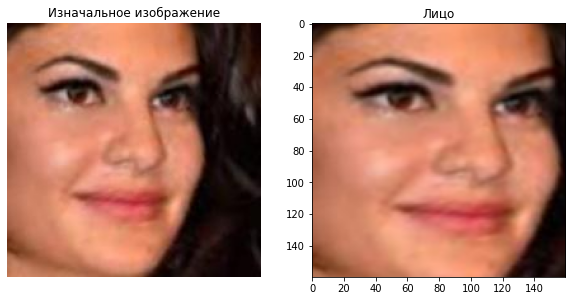

In [5]:
# test_img = './test_img/test1.png'
test_img = './dataset/female/33_1_0_20170119145706157.jpg.chip.jpg'

face = extract_face(test_img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(test_img))
plt.title('Изначальное изображение')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(face)
plt.title('Лицо')
plt.show()

### Загрузка и обработка лиц

In [6]:
X, y = [], []

for label in labels:
    label_path = os.path.join(dataset_path, label)
    print(f'Загрузка изображений из {label_path}')
    
    for image_name in os.listdir(label_path):
        image_path = os.path.join(label_path, image_name)
        face = extract_face(image_path)
        
        if face is not None:
            X.append(face)
            y.append(label)

X = np.array(X)
y = np.array(y)

print(f'\nЗагружено {len(X)} изображений')
print('Распределение классов:', {label: np.sum(y == label) for label in labels})

Загрузка изображений из .\dataset\male
Загрузка изображений из .\dataset\female

Загружено 23440 изображений
Распределение классов: {'male': 12246, 'female': 11194}


### Генерация эмбеддингов для всех изображений

In [7]:
facenet_model = load_model('facenet_keras.h5')

def get_embedding(face_img):
    '''Генерация эмбеддинга для одного лица'''

    face_img = face_img.astype('float32')
    mean, std = face_img.mean(), face_img.std()
    face_img = (face_img - mean) / std
    face_img = np.expand_dims(face_img, axis=0)
    return facenet_model.predict(face_img)[0]

embeddings = np.array([get_embedding(face) for face in X])

print(f'Размерность эмбеддингов: {embeddings.shape}')

embeddings_data = {
    'embeddings': embeddings,
    'labels': y
}

with open('embeddings_data.pkl', 'wb') as f:
    pickle.dump(embeddings_data, f)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








c:\Users\user\Desktop\v1\v2\venv\lib\site-packages\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Размерность эмбеддингов: (23440, 128)


### Класс для обработки изображений

In [8]:
class FaceLoading:
    def __init__(self, dataset_dir, labels, target_size=(160, 160)):
        self.dataset_dir = dataset_dir
        self.labels = labels
        self.target_size = target_size
        self.face_detector = MTCNN()

    def extract_face(self, image_path):
        '''Извлекает лицо из изображения по пути `image_path`'''
        try:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            detections = self.face_detector.detect_faces(img)
            if not detections:
                return None
            
            x, y, w, h = detections[0]['box']
            x, y = abs(x), abs(y)
            face = img[y:y+h, x:x+w]
            return cv2.resize(face, self.target_size)
            
        except Exception as e:
            print(f'Ошибка при обработке {image_path}: {e}')
            return None

    def load_dataset(self):
        '''Загружает весь датасет и возвращает данные в виде (X, y)'''
        X, y = [], []
        
        for label in self.labels:
            label_dir = os.path.join(self.dataset_dir, label)
            if not os.path.exists(label_dir):
                print(f'Папка {label_dir} не найдена, пропускаем...')
                continue
            
            print(f'Загрузка изображений для класса {label}')
            
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                face = self.extract_face(img_path)
                if face is not None:
                    X.append(face)
                    y.append(label)
        
        X = np.array(X)
        y = np.array(y)
        
        print(f'\nЗагружено {len(X)} изображений')
        print('Распределение классов:', {label: np.sum(y == label) for label in labels})
        return X, y

### Подготовка данных и обучение модели

In [9]:
print('\n3. Подготовка данных и обучение модели')

# Кодирование меток
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y_encoded, 
    test_size=0.2, 
    random_state=17,
    shuffle=True
)

# Инициализация и обучение SVM
svm = SVC(
    kernel='rbf', 
    probability=True, 
    random_state=42, 
    class_weight='balanced'
)
svm.fit(X_train, y_train)
print('Модель обучена')



3. Подготовка данных и обучение модели
Модель обучена


### Оценка модели


4. Оценка модели
Точность на обучении: 0.95
Точность на тесте: 0.94
{'accuracy': 0.9411262798634812,
 'female': {'f1-score': 0.9385026737967914,
            'precision': 0.9330970314576872,
            'recall': 0.9439713133124159,
            'support': 2231},
 'macro avg': {'f1-score': 0.9410189310064154,
               'precision': 0.9408389311957297,
               'recall': 0.9412571259276772,
               'support': 4688},
 'male': {'f1-score': 0.9435351882160393,
          'precision': 0.9485808309337721,
          'recall': 0.9385429385429386,
          'support': 2457},
 'weighted avg': {'f1-score': 0.9411402352148999,
                  'precision': 0.9412121541779815,
                  'recall': 0.9411262798634812,
                  'support': 4688}}


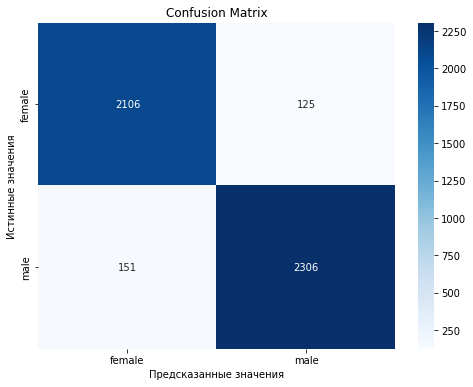

In [10]:
print('\n4. Оценка модели')

# Предсказания
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

# Расчет метрик
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

classification_rep = classification_report(
    y_test, y_test_pred, 
    target_names=encoder.classes_,
    output_dict=True
)

conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f'Точность на обучении: {train_accuracy:.2}')
print(f'Точность на тесте: {test_accuracy:.2}')
pprint(classification_rep)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, 
            yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show()

model_data = {
    'svm': svm,
    'encoder': encoder,
    'metrics': {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'classification_report': classification_rep,
        'confusion_matrix': conf_matrix
    }
}

with open('gender_svm.pkl', 'wb') as f:
    pickle.dump(model_data, f)



### Предсказание на новых данных


5. Предсказание на новых данных


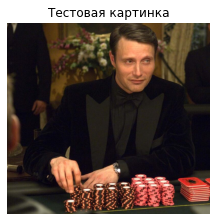

Результат предсказания:
- Пол: male
- Вероятность male: 0.9629811071708108
- Вероятность female: 0.03701889282918925


In [11]:
print('\n5. Предсказание на новых данных')

def predict_gender(image_path):
    '''Определение пола по фотографии'''
    # 1. Извлечение лица
    face = extract_face(image_path)
    if face is None:
        return {'error': 'Лицо не обнаружено'}
    
    # 2. Создание эмбеддинга
    embedding = get_embedding(face)
    
    # 3. Предсказание
    proba = svm.predict_proba([embedding])[0]
    
    # 4. Форматирование результата
    result = {
        'gender': encoder.classes_[np.argmax(proba)],
        'probability': {
            'male': proba[encoder.transform(['male'])[0]],
            'female': proba[encoder.transform(['female'])[0]]
        }
    }
    return result


# Пример предсказания
test_image = './test_img/test1.png'
result = predict_gender(test_image)

# Визуализация результата
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(test_image))
plt.title('Тестовая картинка')
plt.axis('off')

plt.show()

print('Результат предсказания:')
print(f'- Пол: {result["gender"]}')
print(f'- Вероятность male: {result["probability"]["male"]}')
print(f'- Вероятность female: {result["probability"]["female"]}')

### Модель определения пола по фотографии

In [12]:
class GenderClassifier:
    def __init__(self, dataset_path=None, facenet_model_path='facenet_keras.h5', embeddings_path='embeddings_data.pkl'):
        self.__face_loader = FaceLoading(None, ['male', 'female'])
        self.__embedder = load_model(facenet_model_path)
        self.__svm = SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
        self.__encoder = LabelEncoder()
        self.__metrics = {}
        self.__X_test = None
        self.__y_test = None
        self.__embeddings = None
        self.__y = None
        self.__y_encoded = None
        self.__X = None
        
        if os.path.exists(embeddings_path):
            print(f'Найден файл с эмбеддингами: {embeddings_path}')
            self.__embeddings, self.__y = self.__load_embeddings(embeddings_path)
            self.__y_encoded = self.__encoder.fit_transform(self.__y)
            print(f'Загружено {len(self.__embeddings)} эмбеддингов')
        elif dataset_path:
            print('Файл с эмбеддингами не найден, загружаем из датасета')
            self.__load_data(dataset_path, embeddings_path)
        else:
            raise ValueError('Необходимо указать dataset_path или предоставить файл с эмбеддингами')

    @property
    def metrics(self):
        '''Геттер для получения метрик модели'''
        return self.__metrics.copy()

    @property
    def encoder_classes(self):
        '''Геттер для получения классов энкодера'''
        return self.__encoder.classes_

    @property
    def test_accuracy(self):
        '''Геттер для получения точности на тестовой выборке'''
        return self.__metrics.get('test_accuracy', None)

    @property
    def train_accuracy(self):
        '''Геттер для получения точности на тренировочной выборке'''
        return self.__metrics.get('train_accuracy', None)

    def __load_embeddings(self, embeddings_path):
        '''Загружает эмбеддинги из файла'''
        with open(embeddings_path, 'rb') as f:
            data = pickle.load(f)
        return data['embeddings'], data['labels']

    def __load_data(self, dataset_path, embeddings_path):
        '''Загружает и обрабатывает данные, сохраняет эмбеддинги'''
        loader = FaceLoading(dataset_path, ['male', 'female'])
        self.__X, self.__y = loader.load_classes()
        self.__y_encoded = self.__encoder.fit_transform(self.__y)
        self.__embeddings = np.array([self.__get_embedding(face) for face in self.__X])
        self.__save_embeddings(embeddings_path)
        
    def __save_embeddings(self, embeddings_path):
        '''Сохраняет эмбеддинги в файл'''
        data = {
            'embeddings': self.__embeddings,
            'labels': self.__y
        }
        with open(embeddings_path, 'wb') as f:
            pickle.dump(data, f)
        print(f'Эмбеддинги сохранены в {embeddings_path}')

    def __get_embedding(self, face_img):
        '''Извлекает эмбеддинг лица'''
        face_img = face_img.astype('float32')
        mean, std = face_img.mean(), face_img.std()
        face_img = (face_img - mean) / std
        face_img = np.expand_dims(face_img, axis=0)
        return self.__embedder.predict(face_img)[0]

    def train(self, test_size=0.2, random_state=17):
        '''Обучает модель на загруженных данных'''
        X_train, self.__X_test, y_train, self.__y_test = train_test_split(
            self.__embeddings, self.__y_encoded, 
            test_size=test_size, random_state=random_state,
            stratify=self.__y_encoded
        )
        
        self.__svm.fit(X_train, y_train)
        
        y_pred = self.__svm.predict(self.__X_test)
        
        train_acc = self.__svm.score(X_train, y_train)
        test_acc = accuracy_score(self.__y_test, y_pred)
        
        self.__metrics = {
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'classification_report': classification_report(
                self.__y_test, y_pred, 
                target_names=self.__encoder.classes_,
                output_dict=True
            ),
            'overfitting_warning': (train_acc - test_acc) > 0.15
        }
        
        print('Метрики обучения:')
        print(f'Train accuracy: {train_acc:.4f}')
        print(f'Test accuracy: {test_acc:.4f}')
        if self.__metrics['overfitting_warning']:
            print('Предупреждение: возможен переобучение модели!')
        
        self.__save_model('gender_svm.pkl')

    def predict(self, image_path):
        '''Предсказывает пол по изображению'''
        face = self.__face_loader.extract_face(image_path)
        if face is None:
            return {'error': 'Не удалось обнаружить лицо'}
        
        embedding = self.__get_embedding(face)
        proba = self.__svm.predict_proba([embedding])[0]
        
        # Получаем индексы классов
        male_idx = self.__encoder.transform(['male'])[0]
        female_idx = self.__encoder.transform(['female'])[0]
        
        # Создаем словарь вероятностей
        proba_dict = {
            'male': float(proba[np.where(self.__svm.classes_ == male_idx)[0][0]]),
            'female': float(proba[np.where(self.__svm.classes_ == female_idx)[0][0]])
        }
        
        predicted_gender = max(proba_dict, key=proba_dict.get)
        
        return {
            'gender': predicted_gender,
            'probability': proba_dict,
            'metrics': self.metrics 
        }

    def __save_model(self, svm_path):
        '''Сохраняет модель SVM и метрики'''
        model_data = {
            'svm': self.__svm,
            'encoder': self.__encoder,
            'metrics': self.__metrics
        }
        with open(svm_path, 'wb') as f:
            pickle.dump(model_data, f)

    @classmethod
    def load_model(cls, svm_path, facenet_model_path='facenet_keras.h5'):
        '''Загружает сохраненную модель'''
        with open(svm_path, 'rb') as f:
            model_data = pickle.load(f)
        
        model = cls(facenet_model_path=facenet_model_path)
        model.__svm = model_data['svm']
        model.__encoder = model_data['encoder']
        model.__metrics = model_data['metrics']
        return model


try:
    model = GenderClassifier.load_model('gender_svm.pkl')
except FileNotFoundError:
    model = GenderClassifier(dataset_path='./dataset', embeddings_path='embeddings_data.pkl')
    model.train()
pprint(model.metrics)

Найден файл с эмбеддингами: embeddings_data.pkl
Загружено 23440 эмбеддингов
{'classification_report': {'accuracy': 0.9411262798634812,
                           'female': {'f1-score': 0.9385026737967914,
                                      'precision': 0.9330970314576872,
                                      'recall': 0.9439713133124159,
                                      'support': 2231},
                           'macro avg': {'f1-score': 0.9410189310064154,
                                         'precision': 0.9408389311957297,
                                         'recall': 0.9412571259276772,
                                         'support': 4688},
                           'male': {'f1-score': 0.9435351882160393,
                                    'precision': 0.9485808309337721,
                                    'recall': 0.9385429385429386,
                                    'support': 2457},
                           'weighted avg': {'f1-score': 0.94114023

c:\Users\user\Desktop\v1\v2\venv\lib\site-packages\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
